In [1]:
import sys
import os
import torch
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from Arrhythmia.Dataset import load_arrhythmia_dataset
from gmm import GMM 
from model import DAGMM

[INFO] Feature dimension 262 ≠ 274. Adjusting...
Train dataset size: 386
Test dataset size: 226


In [2]:
from torch.utils.data import DataLoader

# Load processed train and test datasets
train_dataset, test_dataset = load_arrhythmia_dataset("arrhythmia.data")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


[INFO] Feature dimension 262 ≠ 274. Adjusting...


In [3]:
model = DAGMM(
    input_dim=274,
    latent_dim=2,
    n_gmm_components=2,
    comp_kwargs={'latent_dim': 2},
    est_kwargs={'hidden_dims': [32], 'activation': torch.nn.Tanh, 'dropout': 0.3},
)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)


In [4]:
n_epochs = 50
for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        x = batch[0]
        out = model(x)
        loss = model.loss_function(x, out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs} — avg train loss: {avg_loss:.4f}")

Epoch 1/50 — avg train loss: 10.2893
Epoch 2/50 — avg train loss: 9.0497
Epoch 3/50 — avg train loss: 8.1958
Epoch 4/50 — avg train loss: 7.5513
Epoch 5/50 — avg train loss: 6.9932
Epoch 6/50 — avg train loss: 6.4934
Epoch 7/50 — avg train loss: 6.0216
Epoch 8/50 — avg train loss: 5.5969
Epoch 9/50 — avg train loss: 5.2082
Epoch 10/50 — avg train loss: 4.8274
Epoch 11/50 — avg train loss: 4.4919
Epoch 12/50 — avg train loss: 4.1805
Epoch 13/50 — avg train loss: 3.9028
Epoch 14/50 — avg train loss: 3.6528
Epoch 15/50 — avg train loss: 3.4599
Epoch 16/50 — avg train loss: 3.2346
Epoch 17/50 — avg train loss: 3.0474
Epoch 18/50 — avg train loss: 2.9735
Epoch 19/50 — avg train loss: 2.8212
Epoch 20/50 — avg train loss: 2.7140
Epoch 21/50 — avg train loss: 2.5828
Epoch 22/50 — avg train loss: 2.4892
Epoch 23/50 — avg train loss: 2.3702
Epoch 24/50 — avg train loss: 2.2620
Epoch 25/50 — avg train loss: 2.1846
Epoch 26/50 — avg train loss: 2.0820
Epoch 27/50 — avg train loss: 2.2279
Epoch 28/

Detected anomalies in test set: 23 / 226
Precision: 0.7826, Recall: 0.5000, F1-score: 0.6102


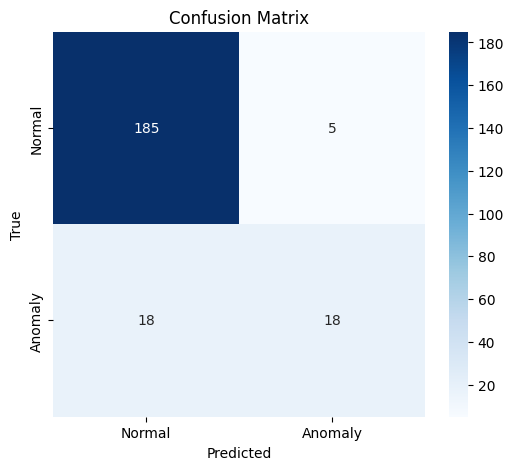

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Set model to evaluation mode
model.eval()

energies = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch  # x: features, y: labels
        out = model(x)
        energies.append(out['energy'].cpu())  # Assuming 'energy' is in the model's output
        true_labels.append(y.cpu())

energies = torch.cat(energies)
true_labels = torch.cat(true_labels)

# Use 70th percentile threshold (tunable)
thr = energies.quantile(0.90)
preds = (energies > thr).int()  # anomaly if energy > threshold

# Ground truth: consider label != 1 as anomaly (per Arrhythmia dataset conventions)
true_anomalies = (true_labels != 1).int()

# Evaluation metrics
precision = precision_score(true_anomalies, preds)
recall = recall_score(true_anomalies, preds)
f1 = f1_score(true_anomalies, preds)
cm = confusion_matrix(true_anomalies, preds)


print(f"Detected anomalies in test set: {preds.sum().item()} / {len(preds)}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

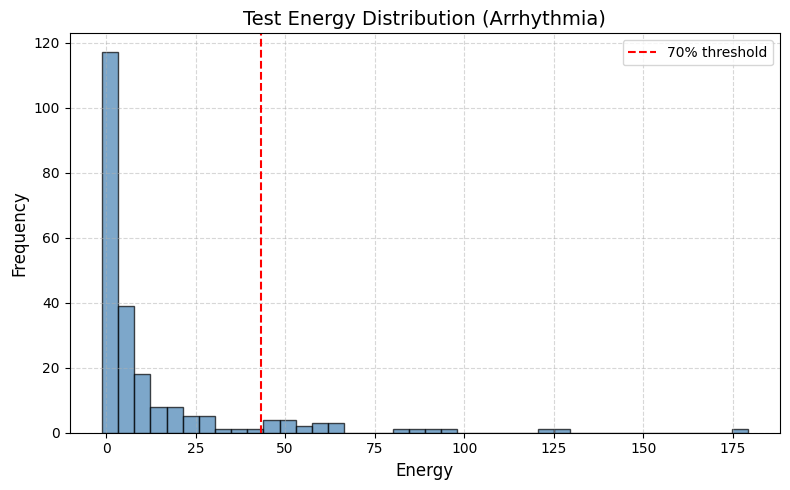

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(energies.numpy(), bins=40, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(thr, color='red', linestyle='--', label='70% threshold')

plt.title("Test Energy Distribution (Arrhythmia)", fontsize=14)
plt.xlabel("Energy", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()